# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [19]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer:

Since there are 6 features (the goods supplied to customers), running PCA on this data set should produce a set of 6 principal components. The component with the highest variance will be used by PCA to create a new "x-axis" for the data set coordinate system. Each of the remaining features will have an orthogonal axis associated with their variances.

When applying ICA, we should expect the creation of new features that are mutually independent from each other. ICA computes a transformation matrix that combines the input features and generates new features. 

### PCA

In [20]:
# Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(data)
print "Original data shape = "
print data.shape

# Print the components and the amount of variance in the data contained in each dimension
print pca.components_
print pca.explained_variance_ratio_


Original data shape = 
(440, 6)
[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [-0.04187648 -0.64564047  0.37546049  0.64629232  0.14938013 -0.02039579]
 [ 0.015986    0.20323566 -0.1602915   0.22018612  0.20793016 -0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: 

The first two components have the largest share of the variance ratio: ~45.9% and ~40.5%, respectively. The remaining components together make up less than 15%! The key hypothesis of PCA is that only a subset of the features in a data set really matter. I would use the first two or three dimensions, since their pricipal component eigenvalues are the largest (or, variance) and they can be visualized.

(440, 2)


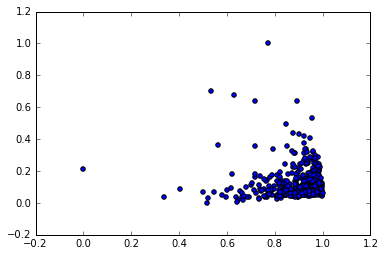

In [32]:
# Example of data reduction: use the first two components...
from sklearn import preprocessing
pca = PCA(n_components=2)
Xt = pca.fit_transform(data)
# Perform scaling...
scaler = preprocessing.MinMaxScaler()
Xt_scaled = scaler.fit_transform(Xt)

print Xt_scaled.shape
pc1 = Xt_scaled[:,0]
pc2 = Xt_scaled[:,1]

plt.scatter(pc1,pc2)

**3)** What do the dimensions seem to represent? How can you use this information?

Answer: 

The principal components create a new coordinate system. By shifting the coordinate system, the axes now represent *combinations* of the original features. This new set of features reduces the dimensionality of the problem, which will make a learning algorithm run more efficiently. From the component ratios (pc1 = 0.45, pc2 = 0.40) and the plot above, it appears that the that a lot of the data is clustered near the origin.


### ICA

In [ ]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
ica = ?

# Print the independent components
print ica.components_

**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: 

## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: 

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [ ]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [ ]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
reduced_data = ?
print reduced_data[:10]  # print upto 10 elements

In [ ]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'

clusters = ?
print clusters

In [ ]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [ ]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

centroids = ?
print centroids

In [ ]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: 

### Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: 

**9)** How would you use that technique to help the company design new experiments?

Answer: 

**10)** How would you use that data to help you predict future customer needs?

Answer: 